# Summarize Text

:::{.callout-info}

This tutorial demonstrates text summarization using built-in chains and [LangGraph](https://langchain-ai.github.io/langgraph/).

A [previous version](https://python.langchain.com/v0.1/docs/use_cases/summarization/) of this page showcased the legacy chains [StuffDocumentsChain](/docs/versions/migrating_chains/stuff_docs_chain/), [MapReduceDocumentsChain](/docs/versions/migrating_chains/map_reduce_chain/), and [RefineDocumentsChain](https://python.langchain.com/v0.2/docs/versions/migrating_chains/refine_docs_chain/). See [here](/docs/versions/migrating_chains/) for information on using those abstractions and a comparison with the methods demonstrated in this tutorial.

:::

Suppose you have a set of documents (PDFs, Notion pages, customer questions, etc.) and you want to summarize the content. 

LLMs are a great tool for this given their proficiency in understanding and synthesizing text.

In the context of [retrieval-augmented generation](/docs/tutorials/rag), summarizing text can help distill the information in a large number of retrieved documents to provide context for a LLM.

In this walkthrough we'll go over how to summarize content from multiple documents using LLMs.

![Image description](../../static/img/summarization_use_case_1.png)

## Concepts

Concepts we will cover are:

- Using [language models](/docs/concepts/#chat-models).

- Using [document loaders](/docs/concepts/#document-loaders), specifically the [WebBaseLoader](https://python.langchain.com/v0.2/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html) to load content from an HTML webpage.

- Two ways to summarize or otherwise combine documents.
  1. [Stuff](/docs/tutorials/summarization#stuff), which simply concatenates documents into a prompt;
  2. [Map-reduce](/docs/tutorials/summarization#map-reduce), for larger sets of documents. This splits documents into batches, summarizes those, and then summarizes the summaries.

Shorter, targeted guides on these strategies and others, including [iterative refinement](/docs/how_to/summarize_refine), can be found in the [how-to guides](/docs/how_to/#summarization).

## Setup

### Jupyter Notebook

This guide (and most of the other guides in the documentation) uses [Jupyter notebooks](https://jupyter.org/) and assumes the reader is as well. Jupyter notebooks are perfect for learning how to work with LLM systems because oftentimes things can go wrong (unexpected output, API down, etc) and going through guides in an interactive environment is a great way to better understand them.

This and other tutorials are perhaps most conveniently run in a Jupyter notebook. See [here](https://jupyter.org/install) for instructions on how to install.

### Installation

To install LangChain run:

```{=mdx}
import Tabs from '@theme/Tabs';
import TabItem from '@theme/TabItem';
import CodeBlock from "@theme/CodeBlock";

<Tabs>
  <TabItem value="pip" label="Pip" default>
    <CodeBlock language="bash">pip install langchain</CodeBlock>
  </TabItem>
  <TabItem value="conda" label="Conda">
    <CodeBlock language="bash">conda install langchain -c conda-forge</CodeBlock>
  </TabItem>
</Tabs>

```


For more details, see our [Installation guide](/docs/how_to/installation).

### LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls.
As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent.
The best way to do this is with [LangSmith](https://smith.langchain.com).

After you sign up at the link above, make sure to set your environment variables to start logging traces:

```shell
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_API_KEY="..."
```

Or, if in a notebook, you can set them with:

```python
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
```

## Overview

A central question for building a summarizer is how to pass your documents into the LLM's context window. Two common approaches for this are:

1. `Stuff`: Simply "stuff" all your documents into a single prompt. This is the simplest approach (see [here](/docs/tutorials/rag#built-in-chains) for more on the `create_stuff_documents_chain` constructor, which is used for this method).

2. `Map-reduce`: Summarize each document on its own in a "map" step and then "reduce" the summaries into a final summary (see [here](https://python.langchain.com/v0.2/api_reference/langchain/chains/langchain.chains.combine_documents.map_reduce.MapReduceDocumentsChain.html) for more on the `MapReduceDocumentsChain`, which is used for this method).

Note that map-reduce is especially effective when understanding of a sub-document does not rely on preceding context. For example, when summarizing a corpus of many, shorter documents. In other cases, such as summarizing a novel or body of text with an inherent sequence, [iterative refinement](/docs/how_to/summarize_refine) may be more effective.

![Image description](../../static/img/summarization_use_case_2.png)

## Setup

First set environment variables and install packages:

In [1]:
%pip install --upgrade --quiet tiktoken langchain langgraph beautifulsoup4

# Set env var OPENAI_API_KEY or load from a .env file
# import dotenv

# dotenv.load_dotenv()

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"

First we load in our documents. We will use [WebBaseLoader](https://python.langchain.com/v0.2/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html) to load a blog post:

In [3]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


Let's next select a LLM:

```{=mdx}
import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs
  customVarName="llm"
/>
```

In [4]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Stuff: summarize in a single LLM call {#stuff}

We can use [create_stuff_documents_chain](https://python.langchain.com/v0.2/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html), especially if using larger context window models such as:

* 128k token OpenAI `gpt-4o` 
* 200k token Anthropic `claude-3-5-sonnet-20240620`

The chain will take a list of documents, insert them all into a prompt, and pass that prompt to an LLM:

In [5]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

The article "LLM Powered Autonomous Agents" by Lilian Weng discusses the development and capabilities of autonomous agents powered by large language models (LLMs). It outlines a system overview that includes three main components: planning, memory, and tool use. 

1. **Planning**: Agents can decompose complex tasks into manageable subgoals and reflect on past actions to improve future performance. Techniques like Chain of Thought (CoT) and Tree of Thoughts enhance reasoning and planning capabilities.

2. **Memory**: The article distinguishes between short-term and long-term memory, with short-term memory being akin to in-context learning and long-term memory utilizing external vector stores for information retrieval. Maximum Inner Product Search (MIPS) algorithms are discussed for efficient memory access.

3. **Tool Use**: The integration of external tools allows agents to extend their capabilities beyond their inherent knowledge. Examples include MRKL systems and frameworks like Huggi

### Streaming

Note that we can also stream the result token-by-token:

In [6]:
for token in chain.stream({"context": docs}):
    print(token, end="|")

|The| article| "|LL|M| Powered| Autonomous| Agents|"| by| Lil|ian|

 W|eng| discusses| the| development| and| capabilities| of| autonomous| agents| powered| by| large| language| models| (|LL|Ms|).| It| outlines| a| system| overview| that| includes| three| main| components|:| planning|,| memory|,| and| tool| use|.| 

|1|.| **|

Planning|**| involves| task| decomposition|,| where| agents| break| down| complex| tasks| into| manageable| sub|go|als|,| and| self|-ref|lection|,| allowing| agents|

 to| learn| from| past| actions| to| improve| future| performance|.

|2|.| **|Memory|**| is| categorized| into| short|-term| and| long|-term| memory|,| with| techniques| like| Maximum| Inner| Product| Search| (|M|IPS|)| used| for|

 efficient| information| retrieval|.

|3|.| **|Tool| Use|**| highlights| the| integration| of| external| APIs| to| enhance|

 the| agent|'s| capabilities|,| illustrated| through| case| studies| like| Chem|Crow| for| scientific| discovery| and| Gener|ative| Agents| for| sim|ulating| human| behavior|.

|The| article| also| addresses| challenges| such| as| finite| context| length|,| difficulties| in| long|-term| planning|,| and| the|

 reliability| of| natural| language| interfaces|.| It| concludes| with| references| to| various| studies| and| projects| that| contribute| to| the| field| of| L|LM|-powered| agents|,|

 emphasizing| their| potential| as| general| problem| sol|vers| beyond| mere| text| generation|.||

### Go deeper

* You can easily customize the prompt. 
* You can easily try different LLMs, (e.g., [Claude](/docs/integrations/chat/anthropic)) via the `llm` parameter.

## Map-Reduce: summarize long texts via parallelization {#map-reduce}

Let's unpack the map reduce approach. For this, we'll first map each document to an individual summary using an LLM. Then we'll reduce or consolidate those summaries into a single global summary.

Note that the map step is typically parallelized over the input documents.

[LangGraph](https://langchain-ai.github.io/langgraph/), built on top of `langchain-core`, supports [map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) workflows and is well-suited to this problem:

- LangGraph allows for individual steps (such as successive summarizations) to be streamed, allowing for greater control of execution;
- LangGraph's [checkpointing](https://langchain-ai.github.io/langgraph/how-tos/persistence/) supports error recovery, extending with human-in-the-loop workflows, and easier incorporation into conversational applications.
- The LangGraph implementation is straightforward to modify and extend, as we will see below.

### Map
Let's first define the prompt associated with the map step, and associated it with the LLM via a [chain](/docs/how_to/sequence/). We can use the same summarization prompt as in the `stuff` approach, above:

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

map_chain = map_prompt | llm | StrOutputParser()

We can also use the Prompt Hub to store and fetch prompts.

This will work with your [LangSmith API key](https://docs.smith.langchain.com/).

For example, see the map prompt [here](https://smith.langchain.com/hub/rlm/map-prompt).

In [8]:
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")

/Users/bagatur/langchain/.venv/lib/python3.11/site-packages/langsmith/client.py:5301: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


### Reduce

We also define a chain that takes the document mapping results and reduces them into a single output.

In [9]:
# Also available via the hub: `hub.pull("rlm/reduce-prompt")`
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain = reduce_prompt | llm | StrOutputParser()

### Orchestration via LangGraph

Below we implement a simple application that maps the summarization step on a list of documents, then reduces them using the above prompts.

Map-reduce flows are particularly useful when texts are long compared to the context window of a LLM. For long texts, we need a mechanism that ensures that the context to be summarized in the reduce step does not exceed a model's context window size. Here we implement a recursive "collapsing" of the summaries: the inputs are partitioned based on a token limit, and summaries are generated of the partitions. This step is repeated until the total length of the summaries is within a desired limit, allowing for the summarization of arbitrary-length text.

First we chunk the blog post into smaller "sub documents" to be mapped:

In [10]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 1003, which is longer than the specified 1000


Generated 14 documents.


Next, we define our graph. Note that we define an artificially low maximum token length of 1,000 tokens to illustrate the "collapsing" step.

In [11]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

LangGraph allows the graph structure to be plotted to help visualize its function:

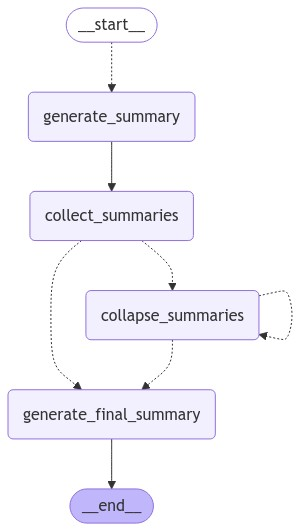

In [12]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

When running the application, we can stream the graph to observe its sequence of steps. Below, we will simply print out the name of the step.

Note that because we have a loop in the graph, it can be helpful to specify a [recursion_limit](https://langchain-ai.github.io/langgraph/reference/errors/#langgraph.errors.GraphRecursionError) on its execution. This will raise a specific error when the specified limit is exceeded.

In [13]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']


['generate_summary']


['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']


['generate_summary']


['generate_summary']


['generate_summary']


['generate_summary']


['collect_summaries']


['collapse_summaries']


['generate_final_summary']


In [14]:
print(step)

{'generate_final_summary': {'final_summary': 'The consolidated summary of the main themes from the provided documents highlights the integration of large language models (LLMs) in autonomous agents, emphasizing their capabilities in planning, memory, and tool use, as well as advancements in neuro-symbolic architectures. Key points include:\n\n1. **Autonomous Agents and LLMs**: LLMs are central to the functioning of autonomous agents, enabling complex task execution through structured planning and self-reflection. Techniques such as Chain of Thought (CoT) and Tree of Thoughts facilitate task decomposition, while external planners support long-term planning.\n\n2. **Challenges and Improvements**: Hallucination remains a significant challenge for autonomous agents. Methods like Chain of Hindsight (CoH) and Algorithm Distillation (AD) are being explored to enhance model outputs and learning efficiency through feedback mechanisms.\n\n3. **Memory and Reinforcement Learning**: The importance 

In the corresponding [LangSmith trace](https://smith.langchain.com/public/9d7b1d50-e1d6-44c9-9ab2-eabef621c883/r) we can see the individual LLM calls, grouped under their respective nodes.

### Go deeper
 
**Customization** 

* As shown above, you can customize the LLMs and prompts for map and reduce stages.

**Real-world use-case**

* See [this blog post](https://blog.langchain.dev/llms-to-improve-documentation/) case-study on analyzing user interactions (questions about LangChain documentation)!  
* The blog post and associated [repo](https://github.com/mendableai/QA_clustering) also introduce clustering as a means of summarization.
* This opens up another path beyond the `stuff` or `map-reduce` approaches that is worth considering.

![Image description](../../static/img/summarization_use_case_3.png)

## Next steps

We encourage you to check out the [how-to guides](/docs/how_to) for more detail on: 

- Other summarization strategies, such as [iterative refinement](/docs/how_to/summarize_refine)
- Built-in [document loaders](/docs/how_to/#document-loaders) and [text-splitters](/docs/how_to/#text-splitters)
- Integrating various combine-document chains into a [RAG application](/docs/tutorials/rag/)
- Incorporating retrieval into a [chatbot](/docs/how_to/chatbots_retrieval/)

and other concepts.